# Introducción al manejo de datos geográficos

## Clase 2: Geolocalización y visualización de registros

### APIs y estrategias de ploteo

![informacion](../imagenes/geolocalizacion.png)

## Introducción 

A lo largo de la clase anterior vimos algunas cuestiones generales del manejo de datos espaciales. Los tipos de geometrías y su implementación en `shapely`, los métodos propios a cada una de ellas, manipulación de geodataframes con `geopandas` y, también, algún avance de cómo visualizar sobre un mapa las transformaciones que ibamos efectuando sobre nuestros datos.

Ahora, intentaremos hacer un repaso de las librerías más utilizadas para el ploteo de información geográfica. Estas herramientas son de gran utilidad ya que, combinándolas con los recursos que venimos revisado, amplían las posibilidades que brinda un SIG de escritorio clásico como QGIS o ARCGIS. Así es que llegamos a la **propuesta para esta clase**.

Para construir nuestras propias visualizaciones, definiremos antes el problema que queremos trabajar espacialmente. Para ello, partiremos de una circunstancia bastante frecuente en el mundo de los datos geográficos: la ausencia de coordenadas o de algún otro atributo que permita su la rápida representación espacial. 

Este problema lo vamos a resolver **en dos partes o secciones:** 

**1)** *APIs de normalización y enriquecimiento de unidades geográficas*: A partir de un caso concreto, introduciremos dos APIs diferentes. Utilizaremos un registro público real que carece de coordenadas geográficas y las reconstruiremos a partir de direcciones físicas. 

**2)** *Visualización de datos geográficos*: Utilizando las coordenadas geográficas generadas previamente, apelaremos a distintas librerías de visualización para comparar los resultados obtenidos mediante el proceso de geolocalización.

### Preparación de los datos

![FACHADAS](../imagenes/fachadas.png)

Una situación bastante común cuando trabajamos con datos que tienen una representación espacial, es que esta no esté disponible como columna o Serie de un DataFrame de pandas. En otras palabras, que no dispongamos de la latitud y la longitud de los datos que buscamos representar espacialmente. 

Supongamos que nuevamente necesitamos trabajar con edificios. Pero en esta oportunidad, no con desarrollos inmobiliarios sino con edificios que han sido catalogados como patrimonio histórico de la ciudad. 

A continuación veremos un [listado de fachadas](https://data.buenosaires.gob.ar/dataset/fachadas) con certificado de conservación. Este dataframe lo bajamos del portal de datos del Gobierno de la Ciudad de Buenos Aires, comúnmente conocido como [data buenos aires](https://data.buenosaires.gob.ar/dataset) - un sitio de consulta de datasets de bastante utilidad.

In [1]:
# Damos un primer vistazo a nuestro DataFrame
import pandas as pd
import numpy as np

In [2]:
fachadas = pd.read_csv('../data/fachadas.csv')

In [3]:
# Como vemos, se trata de un dataset de 26489 registros
len(fachadas)

26489

In [4]:
# Con información geográfica relativa a la sección, manzana, la parcela y dirección donde se encuentra cada fachada
fachadas.columns

Index(['seccion', 'manzana', 'parcela', 'partida', 'calle_nombre',
       'calle_altura', 'vencimiento_certificado'],
      dtype='object')

In [5]:
fachadas.head()

,seccion,manzana,parcela,partida,calle_nombre,calle_altura,vencimiento_certificado
0,21,2,9,429255.0,"ALVAREZ, JULIAN",2531.0,2019-03-12
1,79,89,22,260164.0,"LAMARCA, EMILIO",1014.0,2019-03-30
2,17,14,27,173288.0,SARMIENTO,4579.0,2019-05-03
3,42,16,1,140186.0,DIRECTORIO AV.,1706.0,2019-06-10
4,11,65,6,442215.0,ALVEAR AV.,1974.0,2019-06-16


In [6]:
# Un total de 26464 partidas únicas
len(fachadas.partida.unique())

26464

In [7]:
import datetime

In [8]:
def to_datetime(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

In [9]:
fechas = fachadas['vencimiento_certificado'].fillna('0000-00-00')

Sabemos que las fechas con mayor cantidad de vencimientos son octubre y junio de 2020...

In [10]:
fechas[fechas!='0000-00-00'].map(to_datetime).value_counts()

2020-10-03    65
2020-06-06    65
2020-08-01    62
2020-09-13    62
2020-11-06    62
              ..
2027-08-15     1
2028-08-07     1
2026-09-08     1
2027-12-15     1
2028-08-23     1
Name: vencimiento_certificado, Length: 3115, dtype: int64

In [11]:
fechas[fechas!='0000-00-00'].map(to_datetime).mode()

0   2020-06-06
1   2020-10-03
dtype: datetime64[ns]

In [12]:
# con una gran cantidad de casos que van a vencer en el 2022
fechas[fechas!='0000-00-00'].map(to_datetime).mean()

Timestamp('2022-04-16 21:15:31.498979584')

In [13]:
# y en marzo del 2019, el vencimiento más reciente
fechas[fechas!='0000-00-00'].map(to_datetime).min()

Timestamp('2019-03-12 00:00:00')

Con lo cual, sabemos que se trata de un registro bastante actualizado, con partidas que vencen (mayormente) entre 2020 y 2040...

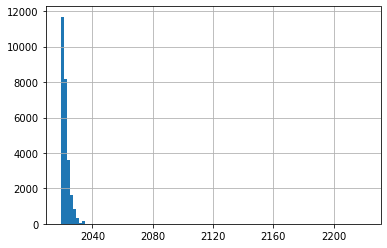

In [14]:
fechas[fechas!='0000-00-00'].map(to_datetime).hist(bins=100);

In [15]:
# y, posiblemente, algún registro erróneo (como se puede apreciar en la cola de nuestro histograma)
fechas[fechas!='0000-00-00'].map(to_datetime).max()

Timestamp('2220-11-20 00:00:00')

In [16]:
fachadas.head()

,seccion,manzana,parcela,partida,calle_nombre,calle_altura,vencimiento_certificado
0,21,2,9,429255.0,"ALVAREZ, JULIAN",2531.0,2019-03-12
1,79,89,22,260164.0,"LAMARCA, EMILIO",1014.0,2019-03-30
2,17,14,27,173288.0,SARMIENTO,4579.0,2019-05-03
3,42,16,1,140186.0,DIRECTORIO AV.,1706.0,2019-06-10
4,11,65,6,442215.0,ALVEAR AV.,1974.0,2019-06-16


Pero lo más importante, si bien este dataset cuenta con referencias geográficas, no sería tan fácil plotear estos registros en un mapa. Si bien no es algo imposible, esto nos demandaría cierto preprocesamiento. Básicamente, porque estas referencias no son más que datos de tipo string. Podríamos construir un código único con las columnas de sección, manzana y parcela y mergearlos con algún shapefile de manzanas. Aunque, para ser más precisos, trataremos de usar la dirección y la altura para conseguir la latitud y la longitud. De esta manera, utilizaremos las coordenadas geográficas de estas direcciones y plotearemos un mapa de puntos para ubicar nuestras fachadas históricas. Comencemos!